In [1]:
import numpy as np


def generate_channel_matrix(n_tx=4, n_rx=4):
    # 복소 가우시안 분포 (0, 1) 을 따르는 4x4 채널 매트릭스 생성
    H_real = np.random.normal(0, 1, (n_rx, n_tx))
    H_imag = np.random.normal(0, 1, (n_rx, n_tx))
    return H_real + 1j * H_imag


def add_noise(y, snr_db):
    # SNR(dB)를 기반으로 잡음 추가
    signal_power = np.mean(np.abs(y) ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise_variance = signal_power / snr_linear
    noise_real = np.random.normal(0, np.sqrt(noise_variance / 2), y.shape)
    noise_imag = np.random.normal(0, np.sqrt(noise_variance / 2), y.shape)
    noise = noise_real + 1j * noise_imag
    return y + noise

In [2]:
def qpsk_decision(x):
    # 실수 및 허수 부분을 각각 결정
    real_part = np.real(x)
    imag_part = np.imag(x)
    x_decided = np.zeros_like(x, dtype=complex)
    x_decided.real = np.where(real_part >= 0, 1, -1)
    x_decided.imag = np.where(imag_part >= 0, 1, -1)
    return x_decided

In [3]:
H = generate_channel_matrix()
print("H.shape:", H.shape)  # (4, 4)이어야 합니다.
print(H)  # 실제로 생성된 복소수 행렬을 출력

H.shape: (4, 4)
[[ 0.6559232 +1.00776985j  1.37968193-0.4953846j   0.81232522+1.16406618j
  -0.7728628 -1.69323302j]
 [-0.61977564+0.24509281j -0.52303609+0.51365192j  0.041427  -0.77979547j
   1.72378562-0.54865538j]
 [-0.77583333+0.02537416j  1.63215489-1.78842123j  0.29483926-0.46002794j
   0.22100286-0.73520612j]
 [-0.81011797-0.87392403j  0.07589549-0.40652561j  0.55790647+0.35083499j
  -0.83324314+1.03361817j]]


In [4]:
def zero_forcing_detector(H, y, snr=None):
    H_pinv = np.linalg.pinv(H)
    x_detected = H_pinv @ y
    return x_detected

In [5]:

def optimal_detector_ml(H, y, snr=None):
    qpsk_symbols = [-1-1j, -1+1j, 1-1j, 1+1j]
    candidates = np.array(np.meshgrid(*[qpsk_symbols]*H.shape[1])).T.reshape(-1, H.shape[1])

    min_distance = np.inf
    best_candidate = None
    for candidate in candidates:
        distance = np.linalg.norm(y - H @ candidate) ** 2
        if distance < min_distance:
            min_distance = distance
            best_candidate = candidate

    x_detected = best_candidate
    return x_detected

In [ ]:
def mmse_detector(H, y, snr=None):
    snr_linear = 10 ** (snr / 10)
    W = snr_linear * H.conj().T @ np.linalg.inv(snr_linear * H @ H.conj().T+ np.eye(H.shape[1]))
    x_detected = W @ y
    return x_detected

In [7]:
def v_blast_detector(H, y, snr=None):
    n_tx = H.shape[1]
    x_estimated = np.zeros(n_tx, dtype=complex)
    H_current = H.copy()
    y_current = y.copy()
    remaining_indices = list(range(n_tx))
    
    for _ in range(n_tx):
        H_pinv = np.linalg.pinv(H_current)
        norms = np.linalg.norm(H_pinv, axis=1)
        min_norm_idx = np.argmin(norms)  # 최소 노름을 가지는 행 선택
        w_k = H_pinv[min_norm_idx, :]
        original_idx = remaining_indices[min_norm_idx]
        
        # 해당 스트림 검출
        x_k = w_k @ y_current
        # QPSK 결정 적용
        x_k_decided = qpsk_decision(np.array([x_k]))[0]
        x_estimated[original_idx] = x_k_decided
        
        # 간섭 제거
        y_current = y_current - H_current[:, min_norm_idx] * x_k_decided
        
        # 채널 행렬 업데이트
        H_current = np.delete(H_current, min_norm_idx, axis=1)
        remaining_indices.pop(min_norm_idx)
    
    return x_estimated

In [13]:
def simulate_achievable_rates(snr_range_db, n_runs=10000):
    detectors = {
        "Optimal": optimal_detector_ml,
        "ZF": zero_forcing_detector,
        "MMSE": mmse_detector,
        "V-BLAST": v_blast_detector
    }
    rates = {name: [] for name in detectors.keys()}
    for snr_db in snr_range_db:
        for name, detector in detectors.items():
            ser_sum = 0
            for _ in range(n_runs):
                H = generate_channel_matrix()
                x_transmitted = np.random.choice([-1-1j, -1+1j, 1-1j, 1+1j], size=H.shape[1])
                y = H @ x_transmitted
                y_noisy = add_noise(y, snr_db)

                x_detected = detector(H, y_noisy, snr= snr_db)
                x_decided = qpsk_decision(x_detected)
                errors = np.sum(x_transmitted != x_decided)
                ser = errors / len(x_transmitted)
                ser_sum += ser
            average_ser = ser_sum / n_runs
            n_streams = H.shape[1]
            bits_per_symbol = np.log2(4)  # QPSK는 2 bits/symbol
            achievable_rate = n_streams * bits_per_symbol * (1 - average_ser)
            rates[name].append(achievable_rate)
    return rates

In [14]:
# Problem 2: Symbol Error Rate (SER)

def simulate_symbol_error_rates(snr_range_db, n_runs=10000):
    detectors = {
        "ZF": zero_forcing_detector,
        "MMSE": mmse_detector
    }

    sers = {name: [] for name in detectors.keys()}

    for snr_db in snr_range_db:
        for name, detector in detectors.items():
            ser_sum = 0

            for _ in range(n_runs):
                H = generate_channel_matrix()
                x_transmitted = np.random.choice([-1-1j, -1+1j, 1-1j, 1+1j], size=H.shape[1])
                y = H @ x_transmitted
                y_noisy = add_noise(y, snr_db)
                x_detected= detector(H, y_noisy, snr= snr_db)
                
                # 결정 과정 추가
                x_decided = qpsk_decision(x_detected)

                errors = np.sum(x_transmitted != x_decided)
                ser_sum += errors / len(x_transmitted)

            sers[name].append(ser_sum / n_runs)

    return sers

In [15]:
# Plot Results
import matplotlib.pyplot as plt
def plot_results(snr_range_db, rates, sers):
    plt.figure(figsize=(14, 6))

    # Achievable Rates
    plt.subplot(1, 2, 1)
    for name, rate in rates.items():
        plt.plot(snr_range_db, rate, label=name)
    plt.title("Achievable Rates vs SNR")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Rate (bits/s/Hz)")
    plt.legend()
    plt.grid()

    # SER
    plt.subplot(1, 2, 2)
    for name, ser in sers.items():
        plt.semilogy(snr_range_db, ser, label=name)
    plt.title("SER vs SNR")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Symbol Error Rate (SER)")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

Achievable Rates: {'Optimal': [5.0994, 5.7490000000000006, 6.4442, 7.098, 7.5614, 7.8366, 7.9514, 7.9898, 7.997, 8.0, 7.9998], 'ZF': [3.7588, 4.1416, 4.6457999999999995, 5.2268, 5.816800000000001, 6.272, 6.7874, 7.1556, 7.421, 7.622, 7.7524], 'MMSE': [4.7466, 5.199199999999999, 5.6386, 6.0766, 6.482, 6.862, 7.1758, 7.421, 7.609, 7.7388, 7.828], 'V-BLAST': [4.212400000000001, 4.7442, 5.3658, 6.0142, 6.6562, 7.203, 7.544, 7.7204, 7.8618, 7.9162, 7.9576]}
Symbol Error Rates: {'ZF': [0.52945, 0.482725, 0.414775, 0.3469, 0.27645, 0.212525, 0.15, 0.1127, 0.07585, 0.04605, 0.03375], 'MMSE': [0.414025, 0.354075, 0.2945, 0.2423, 0.190725, 0.13765, 0.104025, 0.071525, 0.04915, 0.03285, 0.022075]}


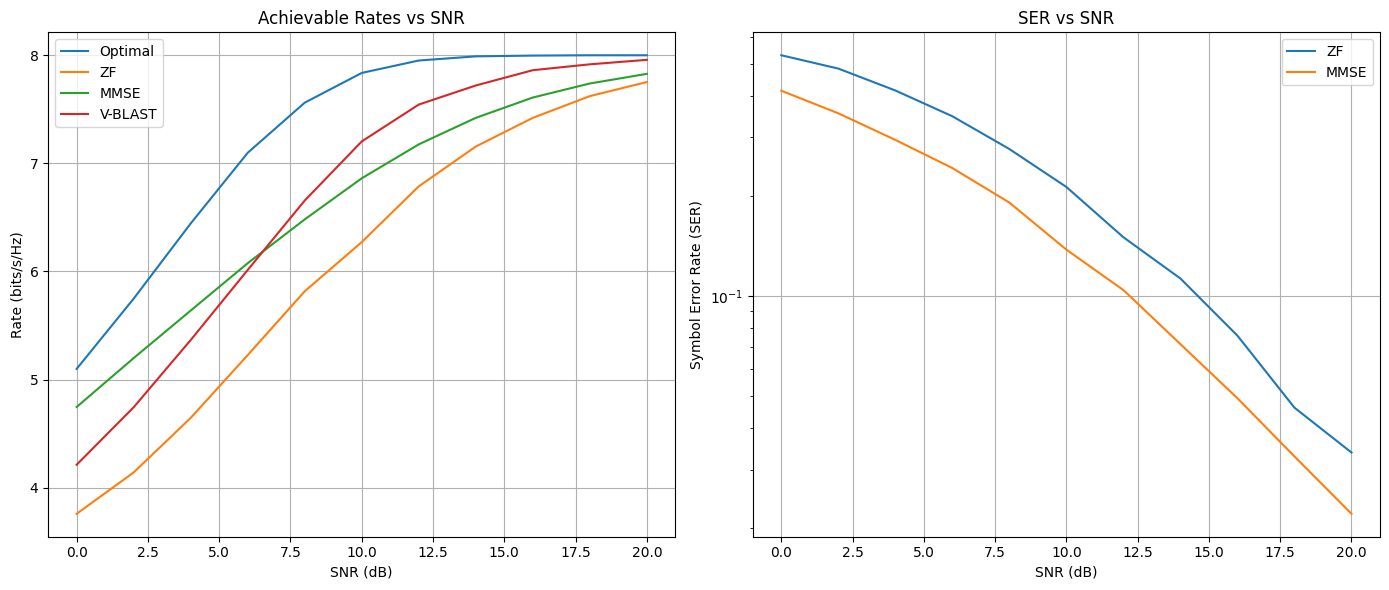

In [16]:
# Main Execution
if __name__ == "__main__":
    np.random.seed(0)
    snr_range_db = np.arange(0, 21, 2)
    
    # Problem 1
    achievable_rates = simulate_achievable_rates(snr_range_db)

    # Problem 2
    symbol_error_rates = simulate_symbol_error_rates(snr_range_db)
    
    print("Achievable Rates:", achievable_rates)
    print("Symbol Error Rates:", symbol_error_rates)

    # Plot results
    plot_results(snr_range_db, achievable_rates, symbol_error_rates)